### Comparison of Clustering Methods

1. Partition Clustering (KMeans):
- KMeans clustering divides data into k clusters by minimizing the variance within each cluster. It assigns points to the nearest cluster centroid, then updates centroids iteratively.
- Advantages: Simple, fast, and efficient for large datasets with clear cluster separations.
- Drawbacks: Sensitive to the initial choice of centroids and requires specifying the number of clusters, k, in advance.

2. Hierarchical Clustering:
- Hierarchical clustering builds a tree of clusters, where each data point starts as its own cluster and pairs of clusters are merged iteratively based on their proximity.
- Advantages: Does not require specifying the number of clusters upfront, and provides a hierarchy of clusters at different levels of granularity.
- Drawbacks: Computationally intensive for large datasets and sensitive to noise and outliers.

3. DBSCAN (Density-Based Clustering):
- DBSCAN identifies clusters based on the density of points. It groups closely packed points (dense regions) together and labels points in low-density regions as outliers.
- Advantages: Can find arbitrarily shaped clusters and does not require specifying the number of clusters.
- Drawbacks: Requires setting two hyperparameters (eps and min_samples), and performance depends heavily on their choice. Does not perform well with varying densities.

### Data Preparation

Labeled Dataset: The labeled dataset being used for clustering is the air quality dataset from the final_cleaned.csv file. This dataset contains quantitative values for various pollutants across different locations.

Removing the Label: The label refers to pollutant concentrations, which are numerical and will be used as features for clustering. Other categorical fields (like location, city) are not needed for clustering.

Quantitative Data: The pollutants' concentrations are already numerical (quantitative), so no conversion is necessary. The latitude and longitude features are also included.

Normalization: Before clustering, the data needs to be normalized to ensure all features have a mean of 0 and standard deviation of 1, which is required by most clustering algorithms. This is done using StandardScaler from sklearn.

Performing PCA: PCA is applied after normalization to reduce the dataset to 3 principal components. This reduces the dimensionality of the dataset, making it easier to visualize and computationally more efficient for clustering algorithms.

In [63]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Load the cleaned dataset
df = pd.read_csv('final_cleaned.csv')

# Keep latitude and longitude separately
lat_lon = df[['location', 'city', 'country', 'timestamp', 'latitude', 'longitude']]

# Pivot the data to have pollutants as separate columns
df_pivot = df.pivot_table(values='value', index=['location', 'city', 'country', 'timestamp'], columns='pollutant').reset_index()

# Merge back the latitude and longitude columns
df_merged = pd.merge(df_pivot, lat_lon, on=['location', 'city', 'country', 'timestamp'])

# Drop rows with missing pollutant values
df_pollutants = df_merged[['pm25', 'pm10', 'no2', 'so2', 'o3', 'co', 'latitude', 'longitude']].dropna()

# Before normalization (to take screenshot of raw data)
print("Before Normalization (raw pollutant data):")
print(df_pollutants.head())  # Display the first 5 rows of the raw pollutant data

# Normalize the data using StandardScaler
scaler = StandardScaler()
df_normalized = scaler.fit_transform(df_pollutants)

# After normalization (to take screenshot of normalized data)
df_normalized = pd.DataFrame(df_normalized, columns=df_pollutants.columns)
print("\nAfter Normalization:")
print(df_normalized.head())  # Display the first 5 rows of normalized data

# Apply PCA to reduce dimensions to 3 components
pca = PCA(n_components=3)
df_pca = pca.fit_transform(df_normalized)

# After applying PCA (to take screenshot of PCA-transformed data)
df_pca = pd.DataFrame(df_pca, columns=['PC1', 'PC2', 'PC3'])
print("\nAfter PCA (with 3 components):")
print(df_pca.head())  # Display the first 5 rows of PCA-transformed data

Before Normalization (raw pollutant data):
         pm25     pm10      no2      so2     o3       co  latitude  longitude
2333  11.0049  15.0595  20.2932  4.04394  45.86  281.522       1.0  53.789233
2334  11.0049  15.0595  20.2932  4.04394  45.86  281.522       1.0  53.789233
2335  11.0049  15.0595  20.2932  4.04394  45.86  281.522       1.0  53.789233
2336  11.0049  15.0595  20.2932  4.04394  45.86  281.522       1.0  53.789233
2337  11.0049  15.0595  20.2932  4.04394  45.86  281.522       1.0  53.789233

After Normalization:
      pm25      pm10       no2       so2        o3        co  latitude  \
0 -0.10143 -0.627765  1.327838  0.359518  0.627202  0.403828 -0.316723   
1 -0.10143 -0.627765  1.327838  0.359518  0.627202  0.403828 -0.316723   
2 -0.10143 -0.627765  1.327838  0.359518  0.627202  0.403828 -0.316723   
3 -0.10143 -0.627765  1.327838  0.359518  0.627202  0.403828 -0.316723   
4 -0.10143 -0.627765  1.327838  0.359518  0.627202  0.403828 -0.316723   

   longitude  
0    1.

In [64]:
# Print variance explained by the first 3 components
explained_variance = pca.explained_variance_ratio_.cumsum()
print(f"\nVariance explained by the first 3 components: {explained_variance[-1]:.2f}")


Variance explained by the first 3 components: 0.71


The PCA reduces the dataset to three dimensions while retaining around 71% of the total variance in the dataset, ensuring that most of the original information is preserved.

### Clustering Code and Results:

KMeans Clustering: The KMeans algorithm is applied to the PCA-reduced 3D dataset. Using the Silhouette Method helps choose the optimal number of clusters (k).

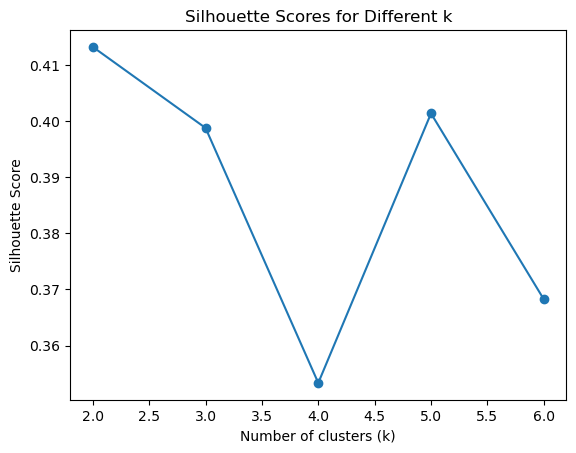

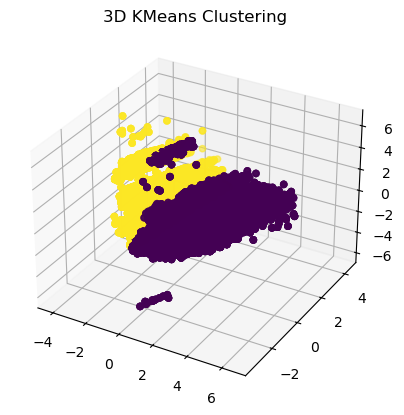

In [44]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Function to find the best number of clusters using Silhouette score
def optimal_kmeans(X):
    silhouette_scores = []
    range_n_clusters = [2, 3, 4, 5, 6]
    
    for n_clusters in range_n_clusters:
        kmeans = KMeans(n_clusters=n_clusters)
        cluster_labels = kmeans.fit_predict(X)
        silhouette_avg = silhouette_score(X, cluster_labels)
        silhouette_scores.append(silhouette_avg)
    
    best_n = range_n_clusters[silhouette_scores.index(max(silhouette_scores))]
    return best_n, silhouette_scores

# Finding the best number of clusters
best_k, silhouette_scores = optimal_kmeans(df_pca)

# Plot silhouette scores
plt.plot([2, 3, 4, 5, 6], silhouette_scores, marker='o')
plt.title('Silhouette Scores for Different k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.show()

# Applying KMeans with the best number of clusters
kmeans = KMeans(n_clusters=best_k)
kmeans.fit(df_pca)
df_pca['Cluster'] = kmeans.labels_

# 3D plot of the clusters
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_pca['PC1'], df_pca['PC2'], df_pca['PC3'], c=df_pca['Cluster'], cmap='viridis')
ax.set_title('3D KMeans Clustering')
plt.show()

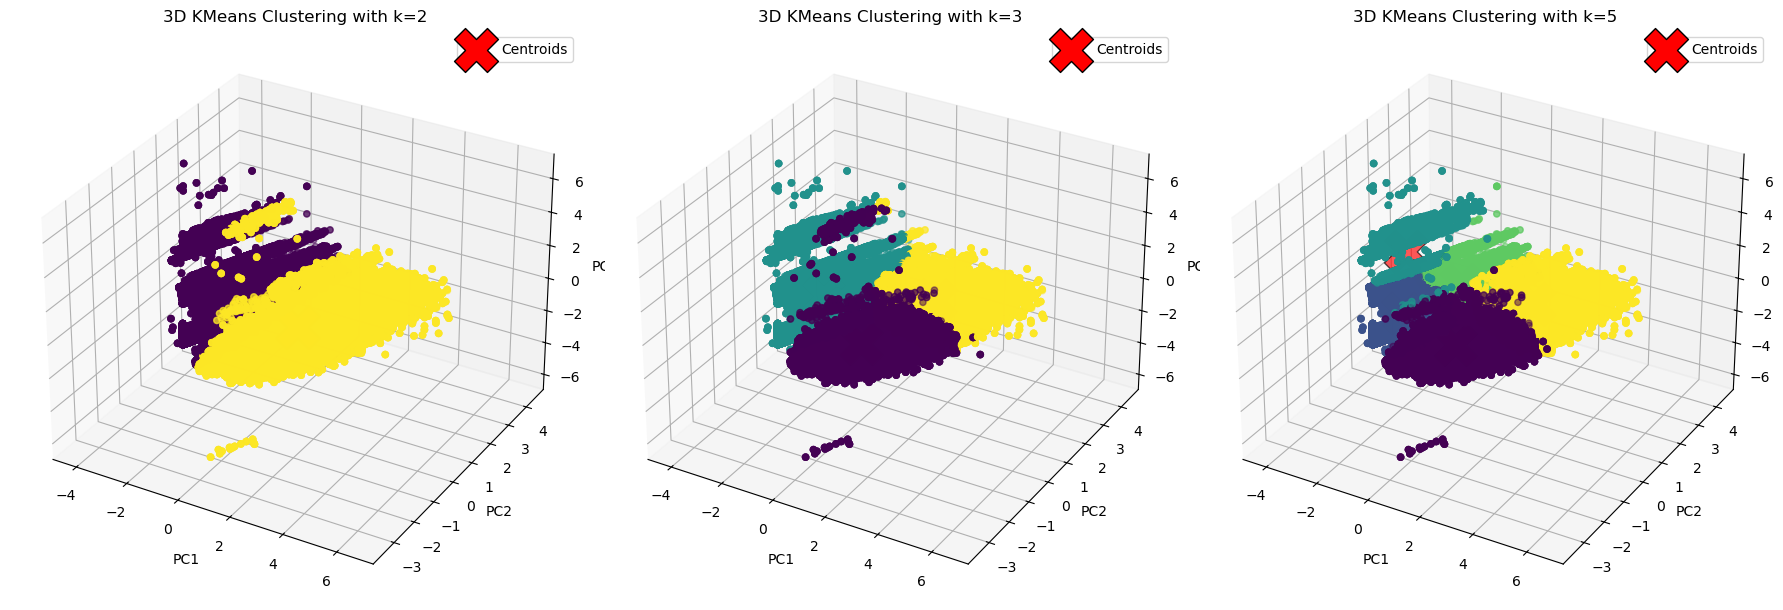

In [90]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans

# Top 3 best `k` values based on silhouette scores
best_k_values = [2, 3, 5]

# Function to plot 3D clusters with centroids
def plot_kmeans_clusters_3d(ax, df_pca, kmeans_model, k):
    # Extract cluster labels and centroids from the KMeans model
    cluster_labels = kmeans_model.labels_
    centroids = kmeans_model.cluster_centers_

    # Plotting the 3D clusters
    scatter = ax.scatter(df_pca['PC1'], df_pca['PC2'], df_pca['PC3'], c=cluster_labels, cmap='viridis', alpha=0.5)

    # Plot the centroids after the points to make sure they are on top
    centroid_plot = ax.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2], 
                               s=1000, c='red', marker='X', edgecolor='black', linewidth=1, label='Centroids')

    # Labels and title
    ax.set_title(f'3D KMeans Clustering with k={k}')
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')

    # Add the legend with centroids
    ax.legend(loc='best')

# Create subplots for horizontal arrangement
fig = plt.figure(figsize=(18, 6))

# Loop through the best_k_values and create a subplot for each
for i, k in enumerate(best_k_values):
    ax = fig.add_subplot(1, 3, i + 1, projection='3d')  # Create subplot in 1 row, 3 columns
    kmeans_model = KMeans(n_clusters=k).fit(df_pca[['PC1', 'PC2', 'PC3']])
    plot_kmeans_clusters_3d(ax, df_pca, kmeans_model, k)

# Show all plots
plt.tight_layout()
plt.show()

Hierarchical Clustering: A dendrogram is used to represent hierarchical clustering results. Clusters are merged based on the distance between points.

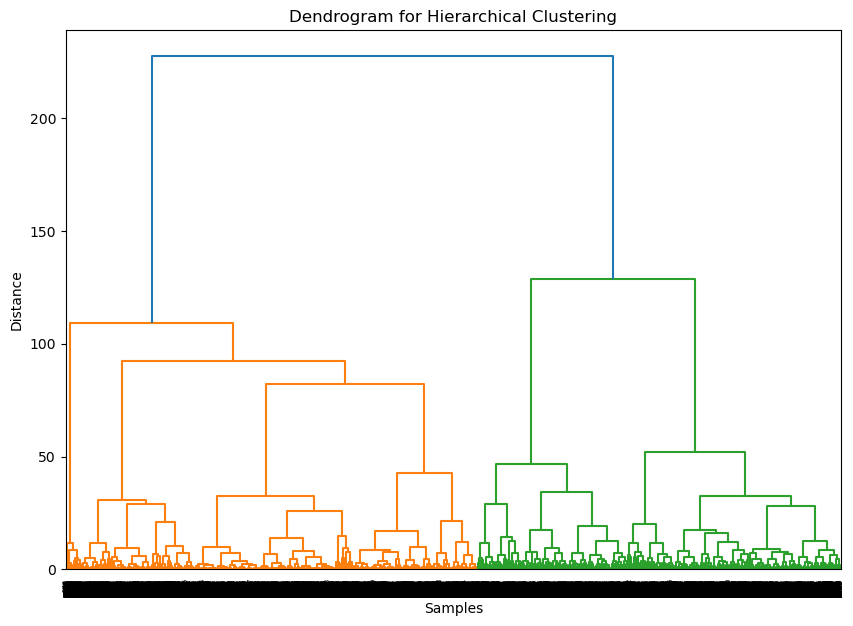

In [49]:
df_sample = df_pca.sample(n=10000, random_state=42)  # Reduce to 10000 samples for dendrogram

# Plot dendrogram for the reduced dataset
plt.figure(figsize=(10, 7))
dendrogram = sch.dendrogram(sch.linkage(df_sample, method='ward'))
plt.title('Dendrogram for Hierarchical Clustering')
plt.xlabel('Samples')
plt.ylabel('Distance')
plt.show()

DBSCAN Clustering: DBSCAN identifies clusters based on the density of points, which is useful for detecting outliers.

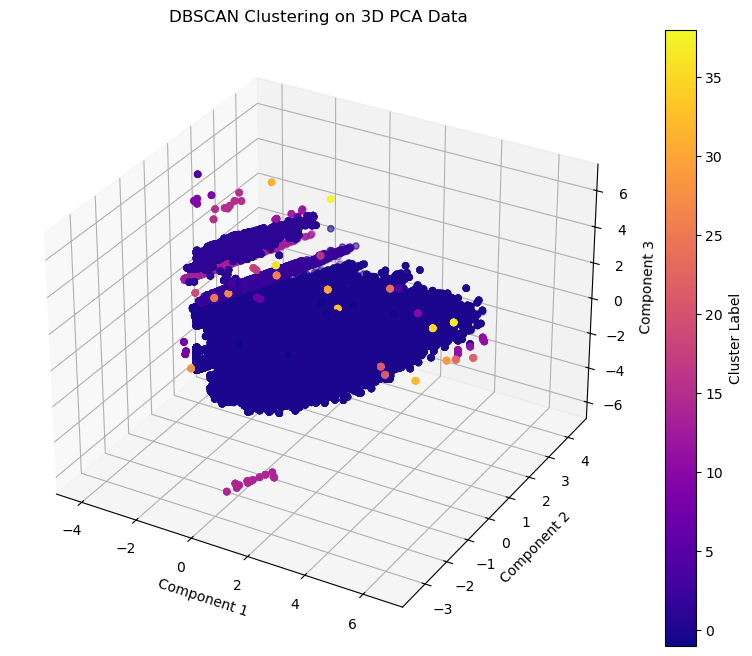

In [86]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import DBSCAN
import numpy as np

# Applying DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(df_pca)

# 3D plot of DBSCAN clustering with a colorbar
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot of the DBSCAN clustering result
sc = ax.scatter(df_pca['PC1'], df_pca['PC2'], df_pca['PC3'], c=dbscan_labels, cmap='plasma')

# Set titles and labels
ax.set_title('DBSCAN Clustering on 3D PCA Data')
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')

# Add a color bar
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('Cluster Label')

plt.show()

### Conclusions:

KMeans performed well with clear spherical clusters, as indicated by the silhouette score.

Hierarchical clustering provides a more nuanced understanding of the data by revealing relationships at different levels of granularity.

DBSCAN detected noise and outliers effectively, but clusters were less well-defined than KMeans.

The results from each clustering method demonstrate the importance of choosing the appropriate algorithm based on the data's structure and the goals of the analysis.